# Data Splitting

In [1]:
# import os
# import shutil
# import random
# from sklearn.model_selection import train_test_split

# # Define paths
# train_dir = 'dataset/train'
# val_dir = 'dataset/val'

# # Calculate the number of classes based on directories in the train folder
# classes = [d.name for d in os.scandir(train_dir) if d.is_dir()]
# num_classes = len(classes)
# print(f"Number of classes: {num_classes}")

In [2]:
# def split_data(train_dir, val_dir, split_size=0.2):
#     for cls in classes:
#         cls_dir = os.path.join(train_dir, cls)
#         images = [os.path.join(cls_dir, img) for img in os.listdir(cls_dir) if img.endswith('.JPG')]

#         # Check if there are images in the class directory
#         if len(images) == 0:
#             print(f"No images found in class {cls}. Skipping this class.")
#             continue

#         # Split the data
#         train_imgs, val_imgs = train_test_split(images, test_size=split_size)

#         # Create corresponding directory in val_dir
#         val_cls_dir = os.path.join(val_dir, cls)
#         os.makedirs(val_cls_dir, exist_ok=True)

#         # Move/copy validation images
#         for img in val_imgs:
#             shutil.move(img, val_cls_dir)  # Use shutil.copy if you want to keep the original

# # Call the function to split the data
# split_data(train_dir, val_dir)

# Train

In [15]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define your transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root='dataset/train', transform=transform)
val_dataset = datasets.ImageFolder(root='dataset/val', transform=transform)

print(train_dataset.class_to_idx)
print(val_dataset.class_to_idx)

# Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

{'10526_Armillaria_mellea': 0, '10527_Armillaria_ostoyae': 1, '10934_Auricularia_auricula-judae': 2, '10937_Auricularia_mesenterica': 3, '11069_Boletus_edulis': 4, '11083_Boletus_pinophilus': 5, '11093_Boletus_reticulatus': 6, '11314_Cantharellus_amethysteus': 7, '11317_Cantharellus_cibarius': 8, '11325_Cantharellus_pallens': 9, '11746_Clitocybe_agrestis': 10, '11748_Clitocybe_alexandri': 11, '11760_Clitocybe_diatreta': 12, '11762_Clitocybe_ditopus': 13, '11767_Clitocybe_fragrans': 14, '11787_Clitocybe_metachroa': 15, '11796_Clitocybe_phaeophthalma': 16, '11797_Clitocybe_phyllophila': 17, '11803_Clitocybe_rivulosa': 18, '11813_Clitocybe_trulliformis': 19, '11816_Clitocybe_vibecina': 20, '12763_Hericium_cirrhatum': 21, '14056_Flammulina_velutipes var. velutipes': 22, '14155_Ganoderma_adspersum': 23, '14158_Ganoderma_applanatum': 24, '14159_Ganoderma_lucidum': 25, '14160_Ganoderma_pfeifferi': 26, '14161_Ganoderma_resinaceum': 27, '14394_Grifola_frondosa': 28, '14667_Hericium_coralloides'

In [4]:
import torch
from torch import nn
import torch.nn.functional as F

# Load Pre-trained DeiT Model
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Adjust the classifier for your number of classes
num_classes = len(train_dataset.classes)
model.head = nn.Linear(model.head.in_features, num_classes)
# model.eval()

Using cache found in /home/samxu/.cache/torch/hub/facebookresearch_deit_main
/home/samxu/documents/apply_ai/final_fungus-detector/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last layers
for param in model.head.parameters():
    param.requires_grad = True

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [7]:
import copy
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            data_loader = train_loader if phase == 'train' else val_loader
            for inputs, labels in tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs} [{phase}]"):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return model

In [9]:
# Train the model
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15)

Epoch 1/15
----------


Epoch 1/15 [train]: 100%|██████████| 241/241 [00:18<00:00, 13.25it/s]


train Loss: 3.1857 Acc: 0.2791


Epoch 1/15 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


val Loss: 2.5655 Acc: 0.3814

Epoch 2/15
----------


Epoch 2/15 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.67it/s]


train Loss: 2.0107 Acc: 0.5096


Epoch 2/15 [val]: 100%|██████████| 62/62 [00:15<00:00,  3.90it/s]


val Loss: 2.1418 Acc: 0.4647

Epoch 3/15
----------


Epoch 3/15 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.63it/s]


train Loss: 1.5498 Acc: 0.6242


Epoch 3/15 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.86it/s]


val Loss: 1.9485 Acc: 0.5040

Epoch 4/15
----------


Epoch 4/15 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.57it/s]


train Loss: 1.2718 Acc: 0.6938


Epoch 4/15 [val]: 100%|██████████| 62/62 [00:15<00:00,  3.88it/s]


val Loss: 1.8332 Acc: 0.5257

Epoch 5/15
----------


Epoch 5/15 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.66it/s]


train Loss: 1.0730 Acc: 0.7503


Epoch 5/15 [val]: 100%|██████████| 62/62 [00:15<00:00,  3.98it/s]


val Loss: 1.7903 Acc: 0.5293

Epoch 6/15
----------


Epoch 6/15 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.65it/s]


train Loss: 0.9294 Acc: 0.7943


Epoch 6/15 [val]: 100%|██████████| 62/62 [00:15<00:00,  3.91it/s]


val Loss: 1.7494 Acc: 0.5353

Epoch 7/15
----------


Epoch 7/15 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.66it/s]


train Loss: 0.8145 Acc: 0.8170


Epoch 7/15 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.84it/s]


val Loss: 1.7203 Acc: 0.5444

Epoch 8/15
----------


Epoch 8/15 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.51it/s]


train Loss: 0.7246 Acc: 0.8433


Epoch 8/15 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.86it/s]


val Loss: 1.6935 Acc: 0.5565

Epoch 9/15
----------


Epoch 9/15 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.57it/s]


train Loss: 0.6460 Acc: 0.8664


Epoch 9/15 [val]: 100%|██████████| 62/62 [00:15<00:00,  3.95it/s]


val Loss: 1.6818 Acc: 0.5590

Epoch 10/15
----------


Epoch 10/15 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.65it/s]


train Loss: 0.5791 Acc: 0.8909


Epoch 10/15 [val]: 100%|██████████| 62/62 [00:15<00:00,  3.90it/s]


val Loss: 1.6834 Acc: 0.5560

Epoch 11/15
----------


Epoch 11/15 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.69it/s]


train Loss: 0.5266 Acc: 0.8987


Epoch 11/15 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.86it/s]


val Loss: 1.6770 Acc: 0.5651

Epoch 12/15
----------


Epoch 12/15 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.83it/s]


train Loss: 0.4760 Acc: 0.9181


Epoch 12/15 [val]: 100%|██████████| 62/62 [00:15<00:00,  3.88it/s]


val Loss: 1.6840 Acc: 0.5575

Epoch 13/15
----------


Epoch 13/15 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.74it/s]


train Loss: 0.4333 Acc: 0.9288


Epoch 13/15 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.83it/s]


val Loss: 1.6992 Acc: 0.5605

Epoch 14/15
----------


Epoch 14/15 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.54it/s]


train Loss: 0.3950 Acc: 0.9384


Epoch 14/15 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.84it/s]


val Loss: 1.6921 Acc: 0.5671

Epoch 15/15
----------


Epoch 15/15 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.55it/s]


train Loss: 0.3616 Acc: 0.9466


Epoch 15/15 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.86it/s]

val Loss: 1.7046 Acc: 0.5681

Best val Acc: 0.568113


In [17]:
model_path = 'model/deit_fungus25_epoch15.pt'
# torch.save(model.state_dict(), model_path)

# Inference

In [26]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
class_names = os.listdir('dataset/train')
class_names.sort()
model.head = nn.Linear(model.head.in_features, num_classes)

model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

Using cache found in /home/samxu/.cache/torch/hub/facebookresearch_deit_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [35]:
def infer_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image)
        probabilities = F.softmax(outputs, dim=1)
        max_probs, preds = torch.max(probabilities, 1)
        return preds.item(), max_probs.item()

In [36]:
import random

image_dir = 'dataset/test/'  # Replace with your image directory path
image_files = random.sample(os.listdir(image_dir), 5)

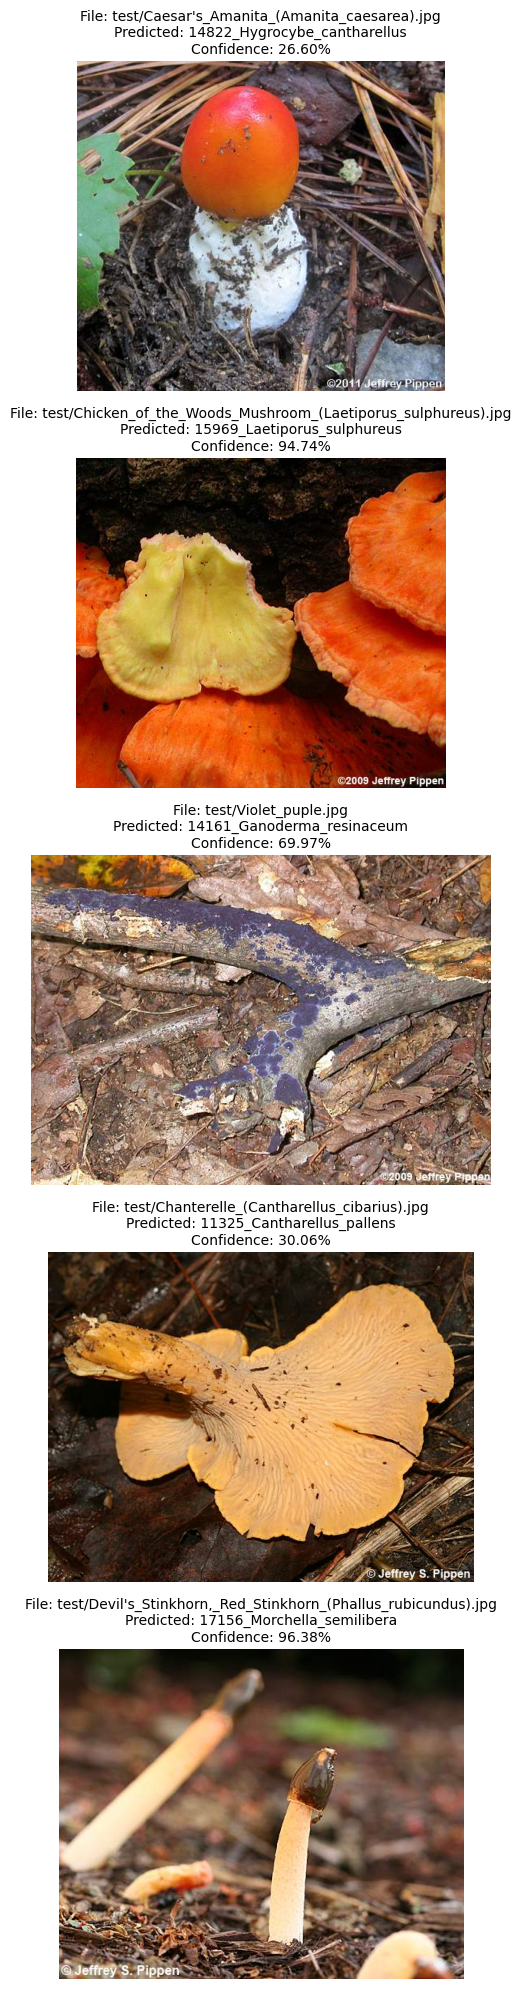

In [48]:
import matplotlib.pyplot as plt
from PIL import Image

num_images = 5
fig, axs = plt.subplots(num_images, 1, figsize=(5, num_images * 4))

for i, image_file in enumerate(image_files):
    image_path = os.path.join(image_dir, image_file)
    pred_class, confidence = infer_image(image_path, model, transform, device)
    class_name = class_names[pred_class]

    parent_dir = os.path.basename(os.path.dirname(image_path))
    display_path = os.path.join(parent_dir, os.path.basename(image_path))
    
    confidence_prec = confidence * 100

    img = Image.open(image_path)
    axs[i].imshow(img)
    axs[i].set_title(f'File: {display_path}\nPredicted: {class_name}\nConfidence: {confidence_prec:.2f}%', fontsize=10)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

# Model Convert

In [60]:
# Apply dynamic quantization
quantized_model = torch.quantization.quantize_dynamic(
    model, 
    {torch.nn.Linear},  # Specify the layers to quantize, in this case, nn.Linear
    dtype=torch.qint8
)

# Save the quantized model
torch.save(quantized_model.state_dict(), model_name + '-quantized_model.pt')

In [61]:
scripted_model = torch.jit.script(quantized_model)
scripted_model.save(model_name + "-model_scripted.pt")

RuntimeError: false INTERNAL ASSERT FAILED at "../aten/src/ATen/quantized/Quantizer.cpp":444, please report a bug to PyTorch. cannot call qscheme on UnknownQuantizer